## Постановка задачи

Мною была выбрана задача генерации карт из спутниковых изображений. Для меня это достаточно актуальная задача ввиду моей специальности. Поскольку я новичок в машинном обучении, прежде чем приступить к данной задаче, я решила несколько "уже решенных" задач, вариаций которых очень много на просторах интернета - превращение яблок в апельсины и наоборот с помощью cyclegan и фреймворка keras. Для решения своей собственной задачи я выбрала готовый датасет на kaggle, модель pix2pix и фреймворк pytorch. 

Спойлер: из-за значительной сложности задачи, ограниченного количества времени и того факта, что сеть обучается невероятно долго, сеть недообучилась и результат не сильно радует.

##Подготовка датасета

Архив скачан с kaggle и загружен на гугл диск. Затем разархивирован для дальнейшего создания даталоадера.

In [0]:
!nvidia-smi

Mon Jun 15 10:17:16 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
!unzip -q /content/gdrive/My\ Drive/k.zip -d data

#Pytorch

In [0]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

Random Seed:  999


#DataLoader


In [0]:
from pathlib import Path
trA_dir = Path('/content/data/maps/maps/trainA')
trB_dir = Path('/content/data/maps/maps/trainB')
tsA_dir = Path('/content/data/maps/maps/testA')
tsB_dir = Path('/content/data/maps/maps/testB')
train = Path('/content/data/maps/maps/train/resized')

In [0]:
class dataset(Dataset):
  def __init__(self, files, mode):
    super().__init__()
    self.files = sorted(files)
    self.len_=len(self.files)
    self.mode = mode
  def __len__(self):
    return self.len_
  def load_sample(self, file):
    image =Image.open(file)
    image.load()
    return image
  def __getitem__(self, index):
    transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.ToPILImage(),
            transforms.CenterCrop(256),
            transforms.ToTensor()])
    transform_test = transforms.Compose([
            transforms.CenterCrop(256),
            transforms.ToTensor()])
    x = self.load_sample(self.files[index])
    if self.mode == 'train':
      x = transform_train(x)
    else:
      x = transform_test(x)
    return x


In [0]:
from PIL import Image

In [0]:
train_A = sorted(list(trA_dir.rglob('*.jpg')))
train_B = sorted(list(trB_dir.rglob('*.jpg')))
test_A = sorted(list(tsA_dir.rglob('*.jpg')))
test_B = sorted(list(tsB_dir.rglob('*.jpg')))
trA_dataset = dataset(train_A, mode = 'train')
trB_dataset = dataset(train_B, mode = 'train')
tsA_dataset = dataset(test_A, mode = 'test')
tsB_dataset = dataset(test_B, mode = 'test')
batch_size = 5
data_tr_A = DataLoader(trA_dataset, batch_size=batch_size, shuffle = True)
data_tr_B = DataLoader(trB_dataset, batch_size=batch_size, shuffle = True)
data_ts_A = DataLoader(tsA_dataset, batch_size=batch_size, shuffle = True)
data_ts_B = DataLoader(tsB_dataset, batch_size=batch_size, shuffle = True)

In [0]:
X = dataset(train_A, mode = 'train')
Y = dataset(train_B, mode = 'train')

In [0]:
X_ts = dataset(test_A, mode = 'test')
Y_ts = dataset(test_B, mode = 'test')

In [0]:
X[0].numpy().shape

(3, 256, 256)

Для трейна

In [0]:
imagesX = []
for i in range(len(X)):
  imagesX.append(X[i].numpy())
imagesY = []
for i in range(len(Y)):
  imagesY.append(Y[i].numpy())

Для теста

In [0]:
imagesX_ts = []
for i in range(len(X_ts)):
  imagesX_ts.append(X_ts[i].numpy())
imagesY_ts = []
for i in range(len(Y_ts)):
  imagesY_ts.append(Y_ts[i].numpy())

Трейн

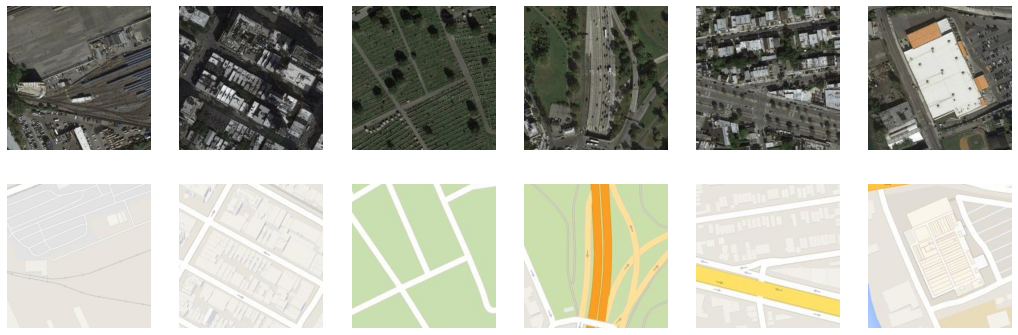

In [0]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(imagesX[i].transpose((1, 2, 0)))

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(imagesY[i].transpose((1, 2, 0)))
plt.show();

Тест

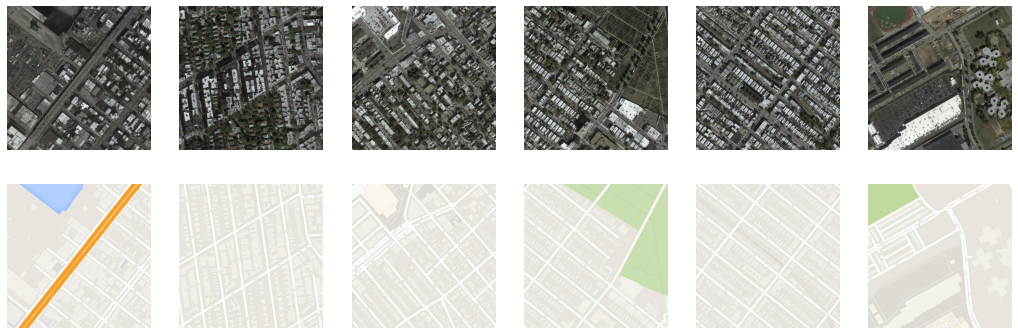

In [0]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(imagesX_ts[i].transpose((1, 2, 0)))

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(imagesY_ts[i].transpose((1, 2, 0)))
plt.show();

In [0]:
batch_size = 1
data_tr = DataLoader(list(zip(imagesX, imagesY)), batch_size=batch_size, shuffle=True, num_workers=4)

In [0]:
batch_size = 1
data_ts = DataLoader(list(zip(imagesX_ts, imagesY_ts)), batch_size=batch_size, shuffle=True)

In [0]:
for X_batch, Y_batch in data_tr:
    # data to device
    X_batch, Y_batch
    break

X_batch.shape, Y_batch.shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 3, 256, 256]))

#Обучение

Напишем функцию для сохранения модели и визуализации промежуточных результатов.

In [0]:
def summarize_performance(step, generator, dataset, n_samples=3):
  for i in range(3):
    pyplot.subplot(3, 3, 1 + i)
    pyplot.axis('off')
    for X, y in data_tr:
      X = X.cpu()
      y = y.cpu()
      break
    imshow(X[0])
    pyplot.subplot(3, 3, 1 + 3 + i)
    pyplot.axis('off')
    imshow(y[0])
    
    pyplot.subplot(3, 3, 1 + 3*2 + i)
    pyplot.axis('off')
    z = generator(X.cuda())
    z = z.cpu()
    imshow(z[0])
    filename1 = 'plot_%06d.png' % (step)
  pyplot.savefig(filename1)
  pyplot.close()
  filename2 = 'model_%06d.pth' % (step)
  torch.save(generator.state_dict(), filename2)
  print('>Saved: %s and %s' % (filename1, filename2))

Визуализация для тензоров

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.detach().numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [0]:
from matplotlib import pyplot

Генератор принимает на вход спутниковое изображение и генерирует из него карту. За основу взята сеть UNet.

In [0]:
class Generator(nn.Module):
  def __init__(self, d=64):
    super(Generator, self).__init__()
    self.conv1 = nn.Sequential(nn.Conv2d(3,d,4,2,1),
                               nn.LeakyReLU(0.2))
    self.conv2 = nn.Sequential(nn.Conv2d(d,d*2,4,2,1),
                             nn.BatchNorm2d(d*2),
                             nn.LeakyReLU(0.2))
    self.conv3 = nn.Sequential(nn.Conv2d(d*2,d*4,4,2,1),
                             nn.BatchNorm2d(d*4),
                             nn.LeakyReLU(0.2))
    self.conv4 = nn.Sequential(nn.Conv2d(d*4,d*8,4,2,1),
                             nn.BatchNorm2d(d*8),
                             nn.LeakyReLU(0.2))
    self.conv5 = nn.Sequential(nn.Conv2d(d*8,d*8,4,2,1),
                             nn.BatchNorm2d(d*8),
                             nn.LeakyReLU(0.2))
    self.conv6 = nn.Sequential(nn.Conv2d(d*8,d*8,4,2,1),
                             nn.BatchNorm2d(d*8),
                             nn.LeakyReLU(0.2))
    self.conv7 = nn.Sequential(nn.Conv2d(d*8,d*8,4,2,1),
                             nn.BatchNorm2d(d*8),
                             nn.LeakyReLU(0.2))
    self.conv8 = nn.Sequential(nn.Conv2d(d*8,d*8,4,2,1),
                               nn.ReLU())
    
    self.deconv1 = nn.Sequential(nn.ConvTranspose2d(d*8,d*8,4,2,1),
                                 nn.BatchNorm2d(d*8),
                                 nn.ReLU(),
                                 nn.Dropout(0.5))
    self.deconv2 = nn.Sequential(nn.ConvTranspose2d(d*8*2,d*8,4,2,1),
                                 nn.BatchNorm2d(d * 8),
                                 nn.ReLU(),
                                 nn.Dropout(0.5))
    self.deconv3 = nn.Sequential(nn.ConvTranspose2d(d*8*2,d * 8,4,2,1),
                                 nn.BatchNorm2d(512),
                                 nn.ReLU(),
                                 nn.Dropout(0.5))
    self.deconv4 = nn.Sequential(nn.ConvTranspose2d(d*8*2,d * 8,4,2,1),
                                 nn.BatchNorm2d(d * 8),
                                 nn.ReLU())
    self.deconv5 = nn.Sequential(nn.ConvTranspose2d(d*8*2,d*4,4,2,1),
                                 nn.BatchNorm2d(d*4),
                                 nn.ReLU())
    self.deconv6 = nn.Sequential(nn.ConvTranspose2d(d * 4 * 2, d * 2,4,2,1),
                                 nn.BatchNorm2d(d*2),
                                 nn.ReLU())
    self.deconv7 = nn.Sequential(nn.ConvTranspose2d(d * 2 * 2, d, 4,2,1),
                                 nn.BatchNorm2d(d),
                                 nn.ReLU())
    self.deconv8 = nn.Sequential(nn.ConvTranspose2d(d * 2, 3, 4,2,1),
                                 nn.Tanh())
  def forward(self,x):
    e1 = self.conv1(x) #32
    e2 = self.conv2(e1) #64
    e3 = self.conv3(e2) #128
    e4 = self.conv4(e3) #256
    e5 = self.conv5(e4) #512
    e6 = self.conv6(e5) #512
    e7 = self.conv7(e6) #512 
    e8 = self.conv8(e7) #512

    d1 = self.deconv1(e8) #512
    d1 = torch.cat((d1,e7),1) #1024
    d2 = self.deconv2(d1) #512
    d2 = torch.cat((d2,e6),1) #1024
    d3 = self.deconv3(d2) #512
    d3 = torch.cat((d3,e5),1) #1024
    d4 = self.deconv4(d3) #256
    d4 = torch.cat((d4,e4),1) #512
    d5 = self.deconv5(d4) #128
    d5 = torch.cat((d5,e3),1) #256
    d6 = self.deconv6(d5) #64
    d6 = torch.cat((d6,e2),1) #128
    d7 = self.deconv7(d6) #32
    d7 = torch.cat((d7,e1),1) #64
    d8 = self.deconv8(d7) #1
    return d8


In [0]:
model = Generator()

In [0]:
a = torch.zeros([1,3,256,256])
model(a).shape

torch.Size([1, 3, 256, 256])

Дискриминатор соединяет вместе два изображения - спутник и карту, а выдает вероятность того, что карта настоящая, а не сгенерированная.

In [0]:
class Discriminator(nn.Module):

    def __init__(self, d = 64):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(6,d,4,2,1),
                                   nn.LeakyReLU(0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(d,d*2, 4,2,1),
                                   nn.BatchNorm2d(d*2),
                                   nn.LeakyReLU(0.2))
        self.conv3 = nn.Sequential(nn.Conv2d(d*2,d*4, 4,2,1),
                                   nn.BatchNorm2d(d*4),
                                   nn.LeakyReLU(0.2))
        self.conv4 = nn.Sequential(nn.Conv2d(d*4,d*8, 4,1,1),
                                   nn.BatchNorm2d(d*8),
                                   nn.LeakyReLU(0.2))
        self.conv5 = nn.Sequential(nn.Conv2d(d*8,d*8, 4,1,1),
                                   nn.BatchNorm2d(d*8),
                                   nn.LeakyReLU(0.2))
        self.conv6 = nn.Sequential(nn.Conv2d(d*8, 1,4,1,1),
                                   nn.Sigmoid())
        
    def forward(self, input, label):
      x=torch.cat([input,label],1)
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.conv5(x)
      x = self.conv6(x)
      return x

In [0]:

def train(dataset):
    # Models
    generator = Generator().cuda()
    discriminator = Discriminator().cuda()
    # Optimizers
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # loss
    L1_loss = nn.L1Loss()
    loss = nn.BCELoss()
    for i in range(200):
      for batch_idx, (X_batch, Y_batch) in enumerate(data_tr):
        discriminator_optimizer.zero_grad()
        X_batch =  X_batch.cuda()
        Y_batch =  Y_batch.cuda()
        G_result = generator(X_batch)
        D_result_t = discriminator(X_batch, Y_batch)
        D_result_f = discriminator(X_batch,G_result)
        D_real_loss = loss(D_result_t, torch.ones_like(D_result_t).cuda())
        D_fake_loss = loss(D_result_f, torch.zeros_like(D_result_f).cuda())
        D_train_loss = (D_real_loss + D_fake_loss)/2
        D_train_loss.backward()
        discriminator_optimizer.step()

        generator.zero_grad()
        G_result = generator(X_batch)
        D_result = discriminator(X_batch, G_result)
        G_train_loss = loss(D_result, torch.ones_like(D_result).cuda())+ L1_loss(G_result, Y_batch)
        G_train_loss.backward()
        generator_optimizer.step()
        
      print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i, D_real_loss, D_fake_loss, G_train_loss))
      if (i) % 10 == 0:
        summarize_performance(i, generator, dataset)

In [0]:
len(data_tr)

1096

In [0]:
train(data_tr)

>0, d1[0.360] d2[0.304] g[1.570]
>Saved: plot_000000.png and model_000000.pth
>1, d1[0.480] d2[0.080] g[2.386]
>2, d1[0.002] d2[0.077] g[3.256]
>3, d1[0.004] d2[0.934] g[3.152]
>4, d1[0.001] d2[0.893] g[3.097]
>5, d1[0.003] d2[0.132] g[2.176]
>6, d1[0.621] d2[0.080] g[2.925]
>7, d1[0.000] d2[0.063] g[3.531]
>8, d1[0.005] d2[0.060] g[3.550]
>9, d1[0.000] d2[0.193] g[2.401]
>10, d1[0.063] d2[0.037] g[4.449]
>Saved: plot_000010.png and model_000010.pth
>11, d1[0.022] d2[0.026] g[7.589]
>12, d1[0.001] d2[0.333] g[2.770]
>13, d1[0.003] d2[0.041] g[3.001]
>14, d1[0.329] d2[0.002] g[6.336]
>15, d1[0.101] d2[0.078] g[3.535]
>16, d1[0.682] d2[0.010] g[4.207]
>17, d1[0.000] d2[0.016] g[6.977]
>18, d1[0.000] d2[0.012] g[5.385]
>19, d1[0.079] d2[0.026] g[5.379]
>20, d1[0.299] d2[0.007] g[4.910]
>Saved: plot_000020.png and model_000020.pth
>21, d1[0.000] d2[0.007] g[5.557]
>22, d1[0.001] d2[0.195] g[2.910]
>23, d1[0.130] d2[0.119] g[3.029]
>24, d1[0.013] d2[0.036] g[3.439]
>25, d1[0.000] d2[0.378] 

KeyboardInterrupt: ignored

Прерываем модель из-за скорого дедлайна. Эта штучка слишком долго учится. К сожалению, это сказывается на результатах.

##Результат

Загружаем веса модели.

In [0]:
the_model = Generator()
the_model.load_state_dict(torch.load('/content/model_000180.pth'))


<All keys matched successfully>

Выдаем батчи из тестового даталоадера для проверки.

In [0]:
for X_batch, Y_batch in data_ts:
    # data to device
    X_batch, Y_batch
    break


In [0]:
X_batch.shape

torch.Size([1, 3, 256, 256])

Генерируем карту из спутнокового изображения Х.

In [0]:
sample = the_model(X_batch)

In [0]:
sample.shape

torch.Size([1, 3, 256, 256])

Посмотрим, что получилось. Мда, это фиаско.

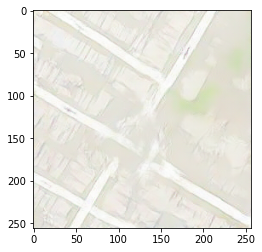

In [0]:
imshow(sample[0])

Оригинал.

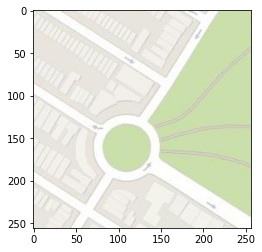

In [0]:
imshow(Y_batch[0])

Что же, получилось объективно не очень. На лицо видно недообучение. Значит, надо обучать дольше и/или попробовать подобрать другие параметры оптимизатора.